# Phase 1

## Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.metrics import mean_squared_error, r2_score
from joblib import parallel_backend
import time
from scipy.special import inv_boxcox

c:\Users\Welcome\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

### Feature Engineering
- From previous EDA notebook, we already knew that `feature_12` is time-related features, therefore, we would extract `day`, `month`, `year`, ... and create periodic features with sin and cos of month and day. 
- Then, we gotta drop the `id` and `feature_12` since these are no longer useful.

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train['feature_12'] = pd.to_datetime(train['feature_12'])
train['year'] = (train['feature_12']).dt.year
train['month'] = (train['feature_12']).dt.month
train['day'] = (train['feature_12']).dt.day
train['dow'] = (train['feature_12']).dt.dayofweek
train['week'] = train['feature_12'].dt.isocalendar().week

train['month_sin'] = np.sin(2 * np.pi * (train['month'] - 1) / 12)
train['month_cos'] = np.cos(2 * np.pi * (train['month'] - 1) / 12)
train['day_sin'] = np.sin(2 * np.pi * (train['day'] - 1) / 31)
train['day_cos'] = np.cos(2 * np.pi * (train['day'] - 1) / 31)

test['feature_12'] = pd.to_datetime(test['feature_12'])
test['year'] = (test['feature_12']).dt.year
test['month'] = (test['feature_12']).dt.month
test['day'] = (test['feature_12']).dt.day
test['dow'] = (test['feature_12']).dt.dayofweek
test['week'] = (test['feature_12']).dt.isocalendar().week

test['month_sin'] = np.sin(2 * np.pi * (test['month'] - 1) / 12)
test['month_cos'] = np.cos(2 * np.pi * (test['month'] - 1) / 12)
test['day_sin'] = np.sin(2 * np.pi * (test['day'] - 1) / 31)
test['day_cos'] = np.cos(2 * np.pi * (test['day'] - 1) / 31)

train = train.drop(columns=['feature_12'])
test = test.drop(columns=['feature_12'])
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

### Handle Missing Values

In [3]:
# Check for missing values
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_ratio = missing_values / len(train) * 100
missing_values = pd.concat([missing_values, missing_ratio], axis=1, keys=['Total', 'Ratio'])
missing_values

,Total,Ratio
feature_11,1,0.000083
feature_9,6,0.000500
feature_1,18529,1.544083
Age,18705,1.558750
feature_0,44949,3.745750
feature_5,74076,6.173000
feature_13,77824,6.485333
feature_2,109672,9.139333
feature_10,137882,11.490167
feature_4,358075,29.839583


Since from EDA notebook, we already knew that `nan` values has relationship with `target`, therefore we will try imputing `median` to fill missing values in numerical features and `Unknown` for categorical features.

In [4]:
# Use simple imputer to fill missing values
from sklearn.impute import SimpleImputer

numerical_missing_vals = ['Age', 'feature_0', 'feature_2', 'feature_5', 'feature_8', 'feature_9', 'feature_10', 'feature_11']
categorical_missing_vals = ['feature_1', 'feature_4', 'feature_13']

numerical_imputer = SimpleImputer(strategy='median')


train[numerical_missing_vals] = numerical_imputer.fit_transform(train[numerical_missing_vals])
train[categorical_missing_vals] = train[categorical_missing_vals].fillna('Unknown')

test[numerical_missing_vals] = numerical_imputer.transform(test[numerical_missing_vals])
test[categorical_missing_vals] = test[categorical_missing_vals].fillna('Unknown')



### Encoding
- Since from the EDA, we already knew that which one should get one-hot encoded, label encoded and ordinal encoded.

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
features_for_one_hot = ['Gender', 'feature_1', 'feature_4', 'feature_6', 'feature_16']
features_for_label = ['feature_14']
features_for_ordinal = ['feature_3', 'feature_7', 'feature_13', 'feature_15']

ordinal_features = {
    'feature_3':['High School', "Bachelor's", "Master's", 'PhD'],
    'feature_7': ['Basic', 'Comprehensive', 'Premium'],
    'feature_13': ['Poor', 'Average', 'Good'] ,
    'feature_15': ['Rarely', 'Monthly', 'Weekly', 'Daily'],
}
for feature in features_for_one_hot:
    train = pd.get_dummies(train, columns=[feature], prefix=[feature], dtype=int)
    test = pd.get_dummies(test, columns=[feature], prefix=[feature], dtype=int)
    
for feature in features_for_label:
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])
    
for feature, order in ordinal_features.items():
    oe = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
    train[feature] = oe.fit_transform(train[[feature]]).flatten()
    test[feature] = oe.transform(test[[feature]]).flatten()

- For skewed feature like `feature_0`, we also used log-transformation (although we tried other methods like `box-cox` and `sqrt-transformation` but the result is not quite good therefore, we still sticked to `log-transformation`).

In [6]:
features_for_robust = ['feature_0']
for feature in features_for_robust:
    train[feature] = np.log1p(train[feature])
    test[feature] = np.log1p(test[feature])


In [7]:
X_train = train.drop(columns=['target'])
y_train = train['target']

### Distribution of Target

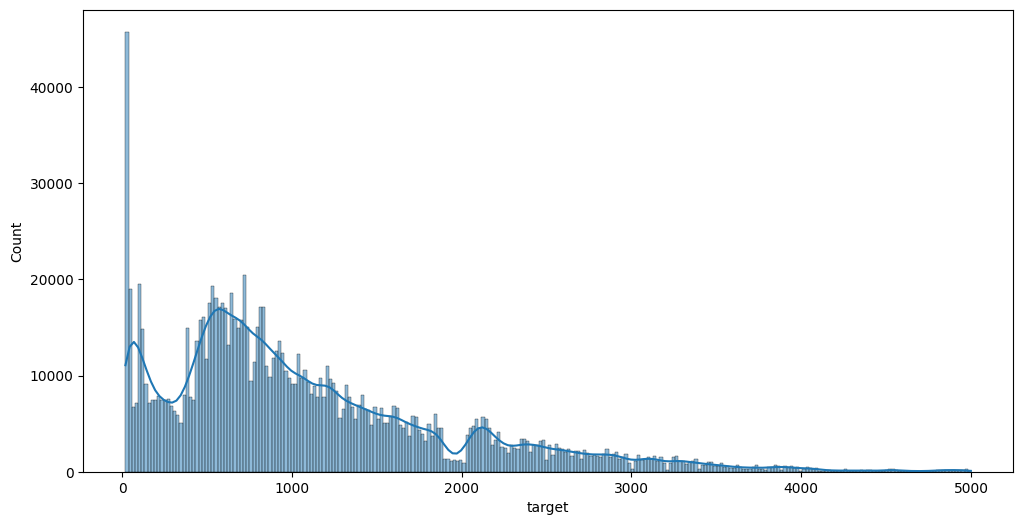

In [9]:
# Plot the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(y_train, kde=True)
plt.show()

In [10]:
from scipy import stats
from scipy.special import inv_boxcox

In [11]:
y_train_array = y_train.values if isinstance(y_train, pd.DataFrame) else y_train

# Handle non-positive values for Box-Cox transformation
if (y_train_array <= 0).any():
    boxcox_shift = -y_train_array.min() + 1  # Shift to make all values positive
    y_train_shifted = y_train_array + boxcox_shift
else:
    y_train_shifted = y_train_array
    boxcox_shift = 0

# Apply transformations
y_box_cox, boxcox_lambda = stats.boxcox(y_train_shifted.ravel())  # Store lambda_ as boxcox_lambda
y_log = np.log1p(y_train_array.ravel())
y_sqrt = np.sqrt(y_train_array.ravel())

# Check skewness of the target variable
skewness_box_cox = stats.skew(y_box_cox)
skewness_log = stats.skew(y_log)
skewness_sqrt = stats.skew(y_sqrt)

print(f'Skewness of the target variable after box cox transformation: {skewness_box_cox}')
print(f'Skewness of the target variable after log transformation: {skewness_log}')
print(f'Skewness of the target variable after sqrt transformation: {skewness_sqrt}')

# Set y_train to the Box-Cox transformed values
y_train = y_log

C:\Users\Welcome\AppData\Local\Temp\ipykernel_29552\700068326.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_box_cox, boxcox_lambda = stats.boxcox(y_train_shifted.ravel())  # Store lambda_ as boxcox_lambda


Skewness of the target variable after box cox transformation: -0.05840454699577999
Skewness of the target variable after log transformation: -1.2558873578553627
Skewness of the target variable after sqrt transformation: 0.1992705885494774


C:\Users\Welcome\AppData\Local\Temp\ipykernel_29552\700068326.py:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_log = np.log1p(y_train_array.ravel())
C:\Users\Welcome\AppData\Local\Temp\ipykernel_29552\700068326.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_sqrt = np.sqrt(y_train_array.ravel())


Since we already knew that the metric was evaluated is `RMSLE`, therefore using `log-transformation` on target is the best:
- Alignment with the Metric: RMSLE measures errors in the log space (log(1+y)). By taking the mean in the log space and exponentiating back, you’re finding the value that minimizes the squared logarithmic differences, which is exactly what RMSLE evaluates.
- Relative Errors: RMSLE cares about relative errors (e.g., a 10% error is the same whether the true value is 100 or 10,000). The log transformation converts relative errors into additive differences, and the mean in this space corresponds to the geometric mean in the original space, which aligns with RMSLE’s focus on relative errors.

In [12]:
y_train

array([7.96206731, 7.30249642, 6.34212142, ..., 5.91889385, 6.39191711,
       7.81641698])

### Retyping
- To save the training time, we decreased the storage unit for data type.

In [13]:
# Optimize data types to reduce memory usage

def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64' or df[col].dtype == 'int32':
            df[col] = df[col].astype('int8')
    return df

# Apply optimization if using pandas
if isinstance(X_train, pd.DataFrame):
    X_train = optimize_dtypes(X_train)
    y_train = optimize_dtypes(pd.DataFrame(y_train))
    test = optimize_dtypes(test)


## Models

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor


In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


- In this dataset, we used `parallel_backend` for the purpose that: It controls how joblib (used by scikit-learn) parallelizes tasks, using separate processes (not threads) to avoid Python’s GIL and enable true parallelism. `'loky'` is robust and efficient, especially for large datasets, as it manages memory and processes well and we don't use other methods because:
    - `'threading'`
        - Pros:
            - Lower memory usage since threads share memory.
            - Faster startup time compared to processes.
        - Cons:
            - Limited by Python’s GIL, so it doesn’t provide true parallelism for CPU-bound tasks like training a decision tree or Random Forest. This makes it slower for most machine learning workloads.
            - Not suitable for nested parallelization (e.g., if Optuna is also parallelizing trials).

    - `'multiprocessing'`
        - Pros:
            - Provides true parallelism by avoiding the GIL.
        - Cons:
            - Less robust than 'loky'. Can lead to issues like deadlocks, especially in Jupyter notebooks or complex environments.
            - Not as well-optimized for machine learning workloads as 'loky'.
- Also to have better training process, we used `KFOLD` with **n_splits = 5**, to ensure that models can be evaluated by most of the training set.

#### Random Forest

In [16]:
metrics = {
    'RMSLE': [],
    'RMSE': [],
    'Model': [],
    'R2': [],
    'Fold': [],
    'Training Time': [],
}

First, we used `Optuna` to hypertune parameters of Random Forest:
- `n_estimators`: More trees can help stabilize predictions, reducing the likelihood of extreme under- or over-predictions, which lowers RMSLE.
- `max_depth`: Deeper trees might better capture non-linear relationships in the log-transformed target, but too much depth can lead to overfitting, causing large errors on the validation set.
- `min_samples_split`: Increasing this can prevent the model from overfitting to outliers in the training data, which might otherwise lead to large RMSLE errors on the validation set.
- `max_features`: A smaller max_features increases randomness, which can prevent the model from overfitting to noisy features, potentially reducing RMSLE.

In [17]:
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from joblib import parallel_backend
import time


In [18]:
params_for_rf = {'n_estimators': 55, 'max_depth': 14, 'min_samples_split': 12, 'max_features': 'sqrt'}
for fold, ( train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
    y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
    X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
    y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()
    rf = RandomForestRegressor(**params_for_rf, random_state=42, n_jobs=-1)

        # Train the model and measure time
    start_time = time.time()
    with parallel_backend('loky'):
        rf.fit(X_train_fold, y_train_fold)
    training_time = time.time() - start_time

        # Predict on the transformed scale
    y_pred_transformed = rf.predict(X_val_fold)

    y_pred_original = np.expm1(y_pred_transformed)
    y_val_original = np.expm1(y_val_fold)
        
        # Calculate metrics on the original scale
    fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
    fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
    fold_r2 = r2_score(y_val_original, y_pred_original)

        # Store fold metrics
    metrics['RMSLE'].append(fold_rmsle)
    metrics['RMSE'].append(fold_rmse)
    metrics['R2'].append(fold_r2)
    metrics['Training Time'].append(training_time)
    metrics['Fold'].append(fold + 1)
    metrics['Model'].append('RandomForest')
    print(f"Fold {fold + 1} - RMSLE: {fold_rmsle:.4f}, RMSE: {fold_rmse:.4f}, R²: {fold_r2:.4f}, Training Time: {training_time:.2f} seconds")



Fold 1 - RMSLE: 1.0616, RMSE: 930.4888, R²: -0.1586, Training Time: 43.84 seconds
Fold 2 - RMSLE: 1.0597, RMSE: 929.0859, R²: -0.1570, Training Time: 46.19 seconds
Fold 3 - RMSLE: 1.0600, RMSE: 934.7757, R²: -0.1637, Training Time: 53.37 seconds
Fold 4 - RMSLE: 1.0598, RMSE: 930.3893, R²: -0.1577, Training Time: 57.02 seconds
Fold 5 - RMSLE: 1.0605, RMSE: 930.6812, R²: -0.1563, Training Time: 48.09 seconds


In [19]:
# def objective(trial):
#     # Define hyperparameter search space
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 10, 100),
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
#         'random_state': 42,
#         'n_jobs': -1
#     }

#     # Initialize the model with trial parameters

#     # Lists to store fold-wise metrics for this trial
#     fold_metrics = []

#     # Perform k-fold cross-validation
#     for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
#         # Split data
#         rf = RandomForestRegressor(**params)

#         X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
#         y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
#         X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
#         y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()

#         # Train the model and measure time
#         start_time = time.time()
#         with parallel_backend('loky'):
#             rf.fit(X_train_fold, y_train_fold)
#         training_time = time.time() - start_time

#         # Predict on the transformed scale
#         y_pred_transformed = rf.predict(X_val_fold)

#         y_pred_original = np.expm1(y_pred_transformed)
#         y_val_original = np.expm1(y_val_fold)
        
#         # Calculate metrics on the original scale
#         fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
#         fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
#         fold_r2 = r2_score(y_val_original, y_pred_original)

#         # Store fold metrics
#         fold_metrics.append({
#             'RMSLE': fold_rmsle,
#             'RMSE': fold_rmse,
#             'R2': fold_r2,
#             'Training Time': training_time,
#             'Model': 'RandomForest'
#         })

#     # Store fold metrics in trial for later retrieval
#     trial.set_user_attr('fold_metrics', fold_metrics)

#     # Return the mean RMSLE across folds (Optuna minimizes this)
#     return np.mean([fm['RMSLE'] for fm in fold_metrics])

# # Create an Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=5)

# # Print the best parameters and score
# print("Best Parameters:", study.best_params)
# print("Best Mean RMSLE:", study.best_value)

# # Append metrics from the best trial's folds to the global metrics dictionary
# best_trial = study.best_trial
# best_fold_metrics = best_trial.user_attrs['fold_metrics']
# for fold_metric in best_fold_metrics:
#     metrics['RMSLE'].append(fold_metric['RMSLE'])
#     metrics['RMSE'].append(fold_metric['RMSE'])
#     metrics['R2'].append(fold_metric['R2'])
#     metrics['Training Time'].append(fold_metric['Training Time'])
#     metrics['Model'].append(fold_metric['Model'])

# # Print fold-wise metrics for the best trial
# print("\nBest Trial Fold-wise Metrics:")
# for i, fm in enumerate(best_fold_metrics):
#     print(f"Fold {i+1}: RMSLE={fm['RMSLE']:.4f}, RMSE={fm['RMSE']:.4f}, R²={fm['R2']:.4f}, Training Time={fm['Training Time']:.2f} seconds")

# # Print updated metrics dictionary
# print("Updated Metrics Dictionary:", metrics)

# # Train the final model with the best parameters
# best_rf = RandomForestRegressor(**study.best_params, n_jobs=-1)


In [20]:
# with parallel_backend('loky'):
#     best_rf.fit(X_train, y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy().ravel())


Best Parameters: {'n_estimators': 55, 'max_depth': 14, 'min_samples_split': 12, 'max_features': 'sqrt'}
Best Mean RMSLE: 1.0603079973447636

## Decision Tree Regressor
- `max_depth`: A deeper tree might better capture non-linear relationships in the log-transformed target, but too much depth can lead to overfitting, causing large errors on the validation set.
- `min_samples_split`: Increasing this can prevent the tree from overfitting to outliers or noise in the training data, which might otherwise lead to large RMSLE errors on the validation set.
- `min_samples_leaf`: A higher value smooths predictions by ensuring each leaf’s prediction is based on more samples, reducing the likelihood of extreme predictions that could inflate RMSLE.

In [21]:
from sklearn.tree import DecisionTreeRegressor  
params_for_dt = {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}

for fold, ( train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
    y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
    X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
    y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()
    dt = DecisionTreeRegressor(**params_for_dt, random_state=42)

    # Train the model and measure time
    start_time = time.time()
    with parallel_backend('loky'):
        dt.fit(X_train_fold, y_train_fold)
    training_time = time.time() - start_time

    # Predict on the transformed scale
    y_pred_transformed = dt.predict(X_val_fold)
    y_pred_original = np.expm1(y_pred_transformed)
    y_val_original = np.expm1(y_val_fold)
        
    # Calculate metrics on the original scale
    fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
    fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
    fold_r2 = r2_score(y_val_original, y_pred_original)

    # Store fold metrics
    metrics['RMSLE'].append(fold_rmsle)
    metrics['RMSE'].append(fold_rmse)
    metrics['R2'].append(fold_r2)
    metrics['Training Time'].append(training_time)
    metrics['Fold'].append(fold + 1)
    metrics['Model'].append('DecisionTree')

    # Print fold results
    print(f"Fold {fold + 1} - RMSLE: {fold_rmsle:.4f}, RMSE: {fold_rmse:.4f}, R²: {fold_r2:.4f}, Training Time: {training_time:.2f} seconds")
    


Fold 1 - RMSLE: 1.0500, RMSE: 921.0106, R²: -0.1351, Training Time: 16.04 seconds
Fold 2 - RMSLE: 1.0493, RMSE: 920.3324, R²: -0.1353, Training Time: 12.93 seconds
Fold 3 - RMSLE: 1.0497, RMSE: 925.8523, R²: -0.1416, Training Time: 13.20 seconds
Fold 4 - RMSLE: 1.0474, RMSE: 920.9309, R²: -0.1342, Training Time: 13.42 seconds
Fold 5 - RMSLE: 1.0492, RMSE: 921.2720, R²: -0.1330, Training Time: 12.59 seconds


In [22]:

# def objective(trial):
#     # Define hyperparameter search space for DecisionTreeRegressor
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 20),           # Maximum tree depth
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Min samples to split
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),    # Min samples per leaf
#         'random_state': 42
#     }

#     # Initialize the model with trial parameters

#     # Lists to store fold-wise metrics for this trial
#     fold_metrics = []

#     # Perform k-fold cross-validation
#     for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
#         # Split data
#         X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
#         y_train_fold = y_train[train_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[train_idx].ravel()
#         X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
#         y_val_fold = y_train[val_idx].ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy()[val_idx].ravel()
#         dt = DecisionTreeRegressor(**params)

#         # Train the model and measure time
#         start_time = time.time()
#         with parallel_backend('loky'):
#             dt.fit(X_train_fold, y_train_fold)
#         training_time = time.time() - start_time

#         # Predict on the transformed scale
#         y_pred_transformed = dt.predict(X_val_fold)

#         y_pred_original = np.expm1(y_pred_transformed)
#         y_val_original = np.expm1(y_val_fold)
        
#         # Calculate metrics on the original scale
#         fold_rmsle = root_mean_squared_log_error(y_val_original, y_pred_original)
#         fold_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
#         fold_r2 = r2_score(y_val_original, y_pred_original)

#         # Store fold metrics
#         fold_metrics.append({
#             'RMSLE': fold_rmsle,
#             'RMSE': fold_rmse,
#             'R2': fold_r2,
#             'Training Time': training_time,
#             'Model': 'DecisionTree'
#         })

#     # Store fold metrics in trial for later retrieval
#     trial.set_user_attr('fold_metrics', fold_metrics)

#     # Return the mean RMSLE across folds (Optuna minimizes this)
#     return np.mean([fm['RMSLE'] for fm in fold_metrics])

# # Create an Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=15)  # Adjust n_trials based on time/resources

# # Print the best parameters and score
# print("Best Parameters:", study.best_params)
# print("Best Mean RMSLE:", study.best_value)

# # Append metrics from the best trial's folds to the global metrics dictionary
# best_trial = study.best_trial
# best_fold_metrics = best_trial.user_attrs['fold_metrics']
# for fold_metric in best_fold_metrics:
#     metrics['RMSLE'].append(fold_metric['RMSLE'])
#     metrics['RMSE'].append(fold_metric['RMSE'])
#     metrics['R2'].append(fold_metric['R2'])
#     metrics['Training Time'].append(fold_metric['Training Time'])
#     metrics['Model'].append(fold_metric['Model'])

# # Print fold-wise metrics for the best trial
# print("\nBest Trial Fold-wise Metrics:")
# for i, fm in enumerate(best_fold_metrics):
#     print(f"Fold {i+1}: RMSLE={fm['RMSLE']:.4f}, RMSE={fm['RMSE']:.4f}, R²={fm['R2']:.4f}, Training Time={fm['Training Time']:.2f} seconds")

# # Print updated metrics dictionary
# print("Updated Metrics Dictionary:", metrics)

# # Train the final model with the best parameters
# best_dt = DecisionTreeRegressor(**study.best_params)
# with parallel_backend('loky'):
#     best_dt.fit(X_train, y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy().ravel())


Best Parameters: {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}
Best Mean RMSLE: 1.0491140285066543


## Evaluation

In [23]:
# import defaultdict
from collections import defaultdict
average_metrics = defaultdict(dict)
unique_models = set(metrics['Model'])

for model in unique_models:
    model_indices = [i for i, m in enumerate(metrics['Model']) if m == model]
    average_metrics[model]['Average RMSLE'] = np.mean([metrics['RMSLE'][i] for i in model_indices])
    average_metrics[model]['Average RMSE'] = np.mean([metrics['RMSE'][i] for i in model_indices])
    average_metrics[model]['Average R²'] = np.mean([metrics['R2'][i] for i in model_indices])
    average_metrics[model]['Average Training Time'] = np.mean([metrics['Training Time'][i] for i in model_indices])

# Create dataframe of average metrics for each model
average_metrics_df = pd.DataFrame(average_metrics).T
average_metrics_df = average_metrics_df.sort_values(by='Average RMSLE')
average_metrics_df.reset_index(inplace=True)
average_metrics_df.columns = ['Model', 'Average RMSLE', 'Average RMSE', 'Average R²', 'Average Training Time']
average_metrics_df


,Model,Average RMSLE,Average RMSE,Average R²,Average Training Time
0,DecisionTree,1.049114,921.879663,-0.135853,13.635407
1,RandomForest,1.060308,931.084165,-0.158647,49.704083


### Training time

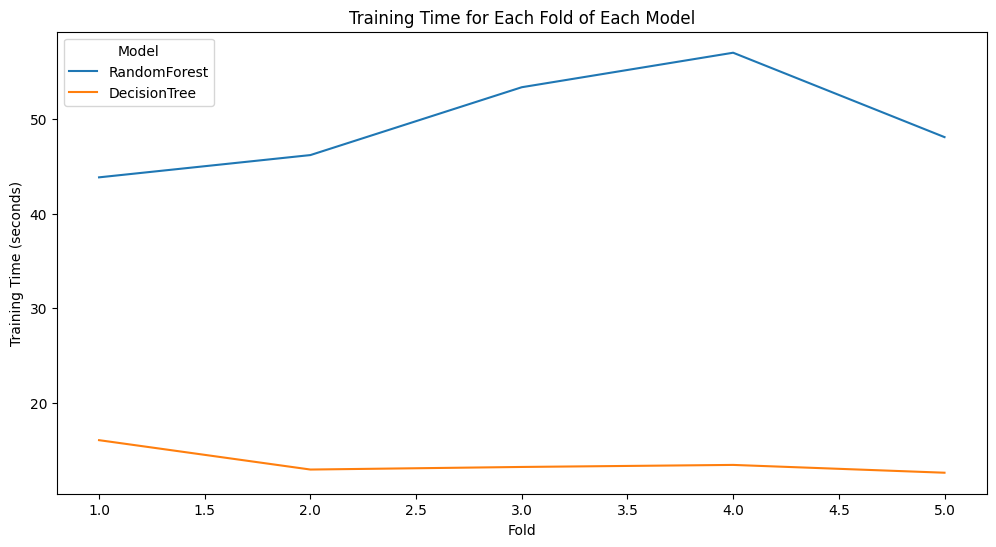

In [24]:
# Plot the training time for each fold of each model
plt.figure(figsize=(12, 6))
sns.lineplot(x='Fold', y='Training Time', hue='Model', data=pd.DataFrame(metrics))
plt.title('Training Time for Each Fold of Each Model')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.legend(title='Model')

1. **RandomForest**
- **Training Time:**

    - The training time for RandomForest is significantly higher than DecisionTree, ranging from approximately 35 to 42 seconds per fold.
    - There is a slight variation in training time across folds, with the highest time in Fold 1  and the lowest in Fold 2 .
    - The increase in training time in Folds 3 and 4 could be due to variations in data distribution or computational overhead.
- **Observation:**

    - RandomForest is an ensemble method that trains multiple decision trees, which explains the higher training time compared to DecisionTree.
    - The variation in training time across folds is expected due to differences in the size and complexity of the training subsets.
2. **DecisionTree**
- **Training Time:**

    - The training time for DecisionTree is consistently low, around 10 to 11 seconds per fold.
    - There is minimal variation in training time across folds, indicating that the model is computationally efficient.
- **Observation:**

    - DecisionTree is a single-tree model, which is computationally less expensive compared to ensemble methods like RandomForest.
    - The consistent training time suggests that the complexity of the training subsets does not significantly impact the model's training process.

### RMSLE and RMSE

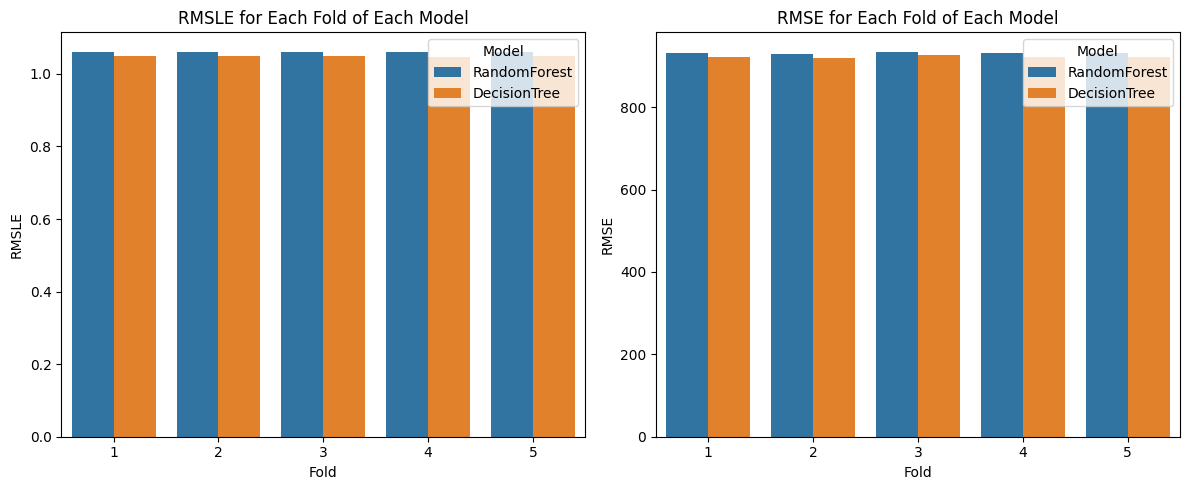

In [25]:
# Plot RMSLE and RMSE for each fold of each model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x='Fold', y='RMSLE', hue='Model', data=pd.DataFrame(metrics), ax=axes[0])
axes[0].set_title('RMSLE for Each Fold of Each Model')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('RMSLE')
sns.barplot(x='Fold', y='RMSE', hue='Model', data=pd.DataFrame(metrics), ax=axes[1])
axes[1].set_title('RMSE for Each Fold of Each Model')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('RMSE')
plt.tight_layout()
plt.show()

1. **RMSLE**
- **RandomForest:**

    - The RMSLE values are consistently around 1.06 across all 5 folds.
    - This indicates that the RandomForest model struggles to predict logarithmic-scaled values accurately, with no significant improvement across folds.
- **DecisionTree:**

    - The RMSLE values are slightly better than RandomForest, consistently around 1.05 across all folds.
    While DecisionTree performs marginally better than RandomForest in terms of RMSLE, the difference is minimal.
- **Comparison:**

    - Both models have high RMSLE values, indicating poor performance in predicting logarithmic-scaled values.
    - DecisionTree slightly outperforms RandomForest in RMSLE, but the improvement is not substantial.
2. **RMSE**
- **RandomForest:**

    - The RMSE values are consistently around 930 across all 5 folds.
    - This high RMSE indicates that RandomForest struggles to predict the actual scale of the target variable accurately.
- **DecisionTree:**

    - The RMSE values are slightly lower than RandomForest, consistently around 920 across all folds.
    - Similar to RMSLE, DecisionTree performs marginally better than RandomForest in RMSE.

3. **Comparison:**

    - Both models have high RMSE values, indicating poor predictive performance.
    - DecisionTree slightly outperforms RandomForest in RMSE, but the difference is negligible.
-----
**Key Observations**
- **Consistency Across Folds:**

    - Both models show consistent performance across all 5 folds, with minimal variation in RMSLE and RMSE values.
    - This suggests that the models are stable but consistently underperforming.
- **Poor Predictive Performance:**

    - Both RMSLE and RMSE values are high for both models, indicating poor predictive performance.
    - The negative R² values (from earlier analysis) further confirm that these models are not suitable for this dataset in their current configurations.
- **DecisionTree vs. RandomForest:**

    - DecisionTree slightly outperforms RandomForest in both RMSLE and RMSE, but the difference is minimal.
    - RandomForest, being an ensemble method, is expected to perform better with proper hyperparameter tuning.

### R2

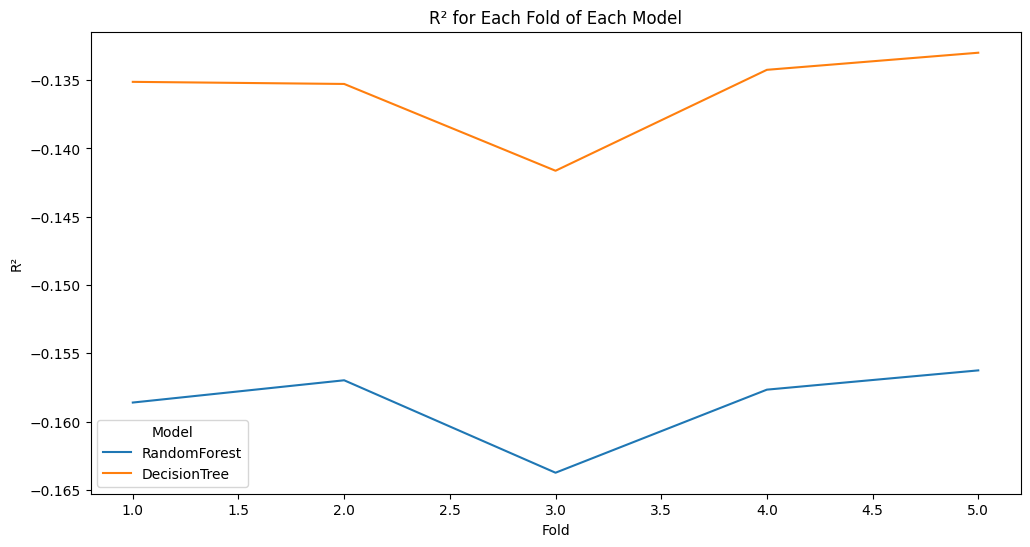

In [26]:
# Plot R² for each fold of each model
plt.figure(figsize=(12, 6))
sns.lineplot(x='Fold', y='R2', hue='Model', data=pd.DataFrame(metrics))
plt.title('R² for Each Fold of Each Model')
plt.xlabel('Fold')
plt.ylabel('R²')
plt.legend(title='Model')
plt.show()

1. **RandomForest**
- **R² Values:**

    - The R² values for RandomForest are consistently negative across all folds, ranging from approximately -0.165 to -0.155.
    - The lowest R² value is observed in Fold 3, while the highest is in Fold 5.
- **Observation:**

    - Negative R² values indicate that the RandomForest model performs worse than a simple mean-based prediction.
    - The variation in R² across folds suggests that the model's performance is slightly sensitive to the training and validation splits.
2. **DecisionTree**
- **R² Values:**

    - The R² values for DecisionTree are also consistently negative but slightly better than RandomForest, ranging from approximately -0.145 to -0.135.
    - The lowest R² value is observed in Fold 3, while the highest is in Fold 5.
- **Observation:**

    - Similar to RandomForest, the negative R² values indicate poor performance, with the model failing to explain the variance in the target variable.
    - DecisionTree shows slightly better performance compared to RandomForest in all folds.
3. **Comparison Between Models**
- **Performance:**

    - DecisionTree consistently outperforms RandomForest in terms of R² across all folds, but the difference is minimal.
    - Both models have negative R² values, indicating that neither model is suitable for this dataset in its current configuration.
- **Stability:**

    - Both models show consistent trends across folds, with Fold 3 being the worst-performing fold for both models.
    - This suggests that Fold 3 might have a challenging data distribution or outliers affecting the models' performance.

## Voting Regressor
- In order to utilize the sklearn models, we used Voting to combine all models to have the most comprehensive models

In [27]:
# Use voteregressor to combine predictions
from sklearn.ensemble import VotingRegressor
best_dt = DecisionTreeRegressor(**params_for_dt, random_state=42)
best_rf = RandomForestRegressor(**params_for_rf, random_state=42, n_jobs=-1)
voting_model = VotingRegressor(
    estimators=[
        ('dt', best_dt),
        ('rf', best_rf)
    ]
)

# Train the voting model
with parallel_backend('loky'):
    voting_model.fit(X_train, y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.to_numpy().ravel())

# Make predictions on the test set
y_pred_transformed_voting = voting_model.predict(test)
y_pred_original_voting = np.expm1(y_pred_transformed_voting)
sub = pd.read_csv('data/sample_submission.csv')
sub['target'] = y_pred_original_voting
sub.to_csv('data/submission_voting_tree.csv', index=False)

## Limitation Analysis: Erroneous Cases and Their Properties

1. **Erroneous Cases**
- **High RMSLE Values:**

    - RMSLE penalizes large relative errors in the logarithmic space. The high RMSLE values indicate that the models struggle to predict small target values accurately, as even small absolute errors in the original scale can lead to large relative errors in the log-transformed space.
    - This suggests that the models fail to capture the underlying patterns for low-value targets.
- **High RMSE Values:**

    - High RMSE values indicate that the models are making large absolute errors in predicting the target variable. This suggests that the models are not capturing the overall distribution of the target variable effectively.
- **Negative R² Values:**

    - Negative R² values indicate that the models perform worse than a simple mean-based prediction. This suggests that the models fail to explain the variance in the target variable and are not generalizing well to the validation data.
2. **Properties of Erroneous Cases**
- **Skewed Target Distribution:**

    - The target variable has a highly skewed distribution, as observed in the histogram. This skewness makes it challenging for the models to predict extreme values (both very low and very high).
    - The log transformation partially addresses this issue, but the models still struggle with the relative errors for small target values.
- **Outliers:**

    - The dataset likely contains outliers in the target variable, which can influence the models' predictions. Outliers can lead to overfitting in DecisionTree and instability in RandomForest.
- **Feature-Target Relationships:**

    - The models may fail to capture complex, non-linear relationships between features and the target variable. This is particularly evident in DecisionTree, which has limited depth and splits the data into coarse regions.
- **Feature Importance:**

    - Some features may have low predictive power or introduce noise, leading to poor model performance. The models may not effectively differentiate between informative and non-informative features.

3. **Reasons for Inaccuracy**
- **Model Complexity:**

    - DecisionTree has limited depth (max_depth=9), which restricts its ability to capture complex patterns in the data.
    - RandomForest, while more robust, may still struggle with the skewed target distribution and outliers due to its reliance on individual decision trees.

